# GAN Model and Training on MNIST

In [23]:
# Import the libraries required
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


### Hyperparameters

In [24]:
# Constants
image_resize_dimension = 64
batch_size = 128
real_label = 1
fake_label = 0

# Hyper parameters
image_channels = 1
z_dim = 256 # latent vector size
hidden_dim_size = 64
lr = 2e-4
num_epochs = 15  # number epochs to train for

In [25]:
# LOAD MNIST Data
# Mnist transform to preprocess the data
transcform_mnist_norm = transforms.Normalize((0.5,),(0.5,)).to(default_device)
transform_mnist = transforms.Compose([transforms.ToTensor(), transcform_mnist_norm, transforms.Resize(image_resize_dimension)])

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size, shuffle=True)

In [26]:
# Print some of the MNIST dataset if flag is set
print_sample = False
if print_sample:
    real_batch = next(iter(trainloader_mnist))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [27]:
# Proper way to initialize weights for the generator and discriminator networks based on reasearch paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [28]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim=100, hidden_layer_size=64, img_channels=1):
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(z_dim, hidden_layer_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 8, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 4, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 2, hidden_layer_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(hidden_layer_size, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(default_device)

    def forward(self, input):
        return self.main(input)
    

class DCDiscriminator(nn.Module):
    def __init__(self, hidden_layer_size=64, img_channels=1):
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(img_channels, hidden_layer_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(hidden_layer_size, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(hidden_layer_size * 2, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(hidden_layer_size * 4, hidden_layer_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(hidden_layer_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(default_device)

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [29]:
# Initialize BCELoss function
criterion = nn.BCELoss()

generator_cifar = DCGenerator(z_dim, hidden_dim_size, image_channels)
generator_cifar.apply(weights_init)
# print(generator_cifar)
discriminator_cifar = DCDiscriminator(hidden_dim_size, image_channels)
discriminator_cifar.apply(weights_init)
# print(discriminator_cifar)

# Optimizers
optimizerG_cifar = optim.Adam(generator_cifar.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD_cifar = optim.Adam(discriminator_cifar.parameters(), lr=lr, betas=(0.5, 0.999))


## Train the Model

In [30]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
jsd_list = []
iters = 0

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(batch_size, z_dim, 1, 1, device=default_device)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader_mnist, 0):

        # (1) Update the discriminator with real data
        discriminator_cifar.zero_grad()
        # Format batch
        real_cpu = data[0].to(default_device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=default_device)
        # Forward pass real batch through D
        output_real = discriminator_cifar(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output_real, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output_real.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=default_device)
        # Generate fake image batch with G
        fake = generator_cifar(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator_cifar(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_cifar.step()

        # (3) Update the generator with fake data
        generator_cifar.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output_fake = discriminator_cifar(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output_fake, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output_fake.mean().item()
        # Update G
        optimizerG_cifar.step()

        
        # JSD Calculation
        p_real = torch.mean(output_real).item()
        p_fake = torch.mean(output_fake).item()
        p_mixed = (p_real + p_fake) / 2
        jsd = 0.5 * (p_real * torch.log2(torch.tensor(p_real) / torch.tensor(p_mixed)) + 
            p_fake * torch.log2(torch.tensor(p_fake) / torch.tensor(p_mixed)))
        jsd_list.append(jsd)

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tJSD: %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader_mnist),
                     errD.item(), errG.item(), jsd, D_x, D_G_z1, D_G_z2))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader_mnist)-1)):
            with torch.no_grad():
                fake = generator_cifar(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/469]	Loss_D: 1.5068	Loss_G: 2.8644	D(x): 0.1002	JSD: 0.4317	D(G(z)): 0.3680 / 0.0749
[1/15][0/469]	Loss_D: 0.0000	Loss_G: 35.2408	D(x): 0.5000	JSD: 1.0000	D(G(z)): 0.0000 / 0.0000
[2/15][0/469]	Loss_D: 0.0000	Loss_G: 37.0146	D(x): 0.5000	JSD: 1.0000	D(G(z)): 0.0000 / 0.0000
[3/15][0/469]	Loss_D: 0.4773	Loss_G: 1.5272	D(x): 0.0740	JSD: 0.7045	D(G(z)): 0.0814 / 0.2663
[4/15][0/469]	Loss_D: 0.3101	Loss_G: 2.7309	D(x): 0.2777	JSD: 0.8935	D(G(z)): 0.1596 / 0.0875
[5/15][0/469]	Loss_D: 1.5482	Loss_G: 4.1287	D(x): 0.3844	JSD: 0.9662	D(G(z)): 0.6752 / 0.0386
[6/15][0/469]	Loss_D: 0.1598	Loss_G: 3.4126	D(x): 0.3479	JSD: 0.9280	D(G(z)): 0.0721 / 0.0492
[7/15][0/469]	Loss_D: 0.5431	Loss_G: 5.0956	D(x): 0.4155	JSD: 0.8990	D(G(z)): 0.3013 / 0.0098
[8/15][0/469]	Loss_D: 0.4542	Loss_G: 1.7811	D(x): 0.1369	JSD: 0.8002	D(G(z)): 0.1820 / 0.2034
[9/15][0/469]	Loss_D: 0.0480	Loss_G: 5.1917	D(x): 0.4609	JSD: 0.9868	D(G(z)): 0.0327 / 0.0090
[10/15][0/469]	Loss_D: 0.1409	Lo

## Plot the Results

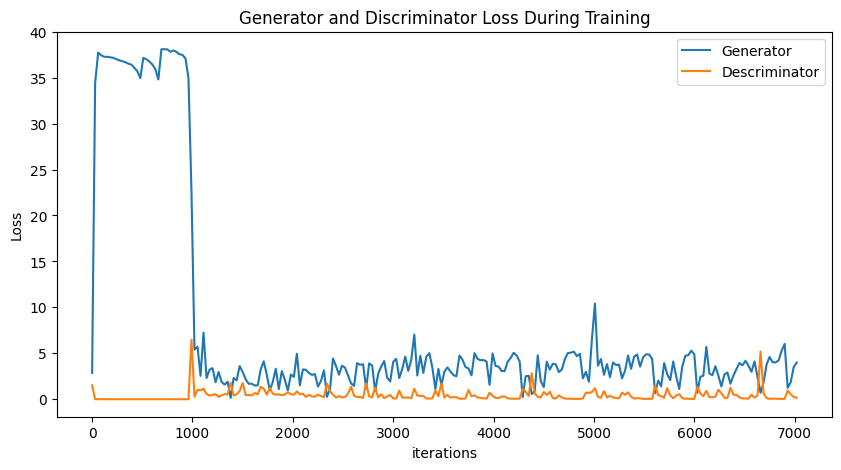

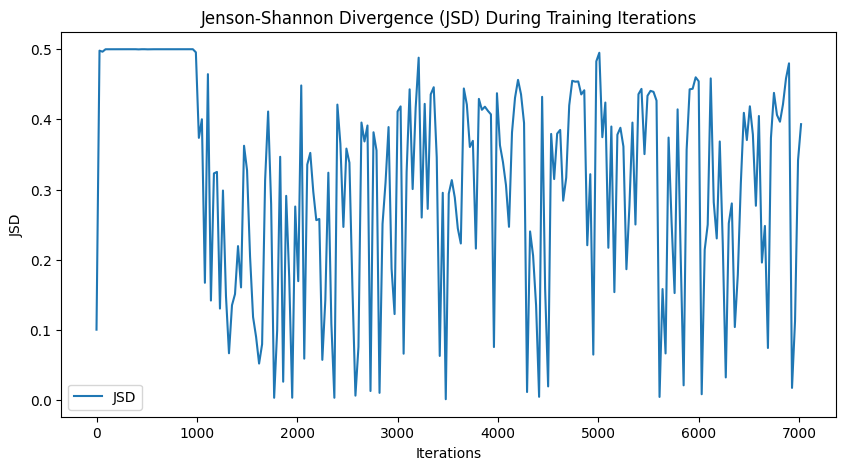

In [33]:
plot_every = 30

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(0, len(G_losses), plot_every), G_losses[::plot_every],label="Generator")
plt.plot(range(0, len(D_losses), plot_every), D_losses[::plot_every],label="Descriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Jenson-Shannon Divergence (JSD) During Training Iterations")
plt.plot(range(0, len(jsd_list), plot_every), jsd_list[::plot_every],label="JSD")
plt.xlabel("Iterations")
plt.ylabel("JSD")
plt.legend()
plt.show()

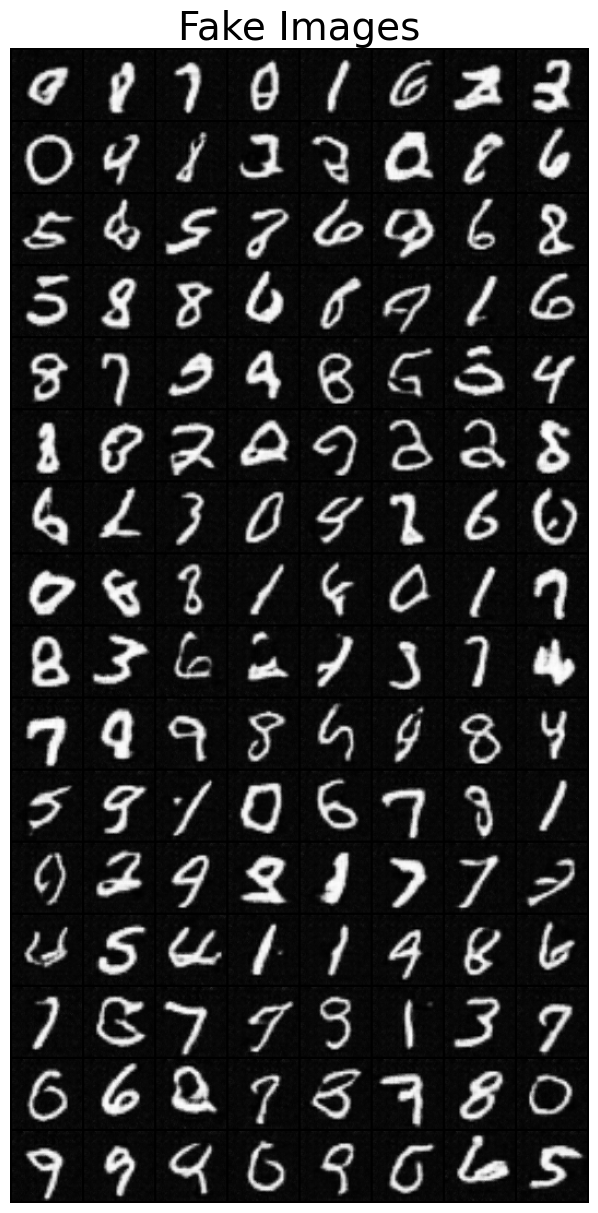

In [32]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader_mnist))

# Plot the real images
plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

new_list = img_list[0:64]

# Plot the fake images from the last epoch
# plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images", fontsize=28)
plt.imshow(np.transpose(new_list[-1],(1,2,0)))
plt.show()